# Lab: Hamiltonian Monte Carlo and Linear Regression

AM207: Verena Kaynig-Fittkau & Pavlos Protopapas Harvard University 

Lab: Xufei Wang

Date: Mar 27 2015


------

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import norm
from statsmodels.tsa.stattools import acf
import seaborn as sns
from mpl_toolkits.mplot3d.axes3d import Axes3D
from statsmodels.formula.api import ols
from scipy.stats import distributions
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

## Hamiltonian Monte Carlo

Hamiltonian Monte Carlo is a combination of MCMC and Molecular Dynamics. The core idea behind Hamiltonian Monte Carlo is that it is possible to augment the target distribution from which you're trying to sample to create a joint distribution in which the additional random variables can be used to control the dynamics with which you traverse your target distribution. It borrows ideas from Gibbs sampling and data augmentation. Hamiltonian Monton Carlo could also tunning the stepsize based on the distribution.

### A simple example

In [2]:
Sigma = [[1,0.99],[0.99,1]]
InvSigma = np.matrix(np.linalg.inv(Sigma))
def logf(x0, x1):
    return -(x0**2*InvSigma[0,0]+2*x0*x1*InvSigma[0,1]+x1**2*InvSigma[1,1])/2.0

def f(x0, x1):
    return np.exp(logf(x0, x1))

In [3]:
x0 = np.linspace(-2.5,2.5,200)
x1 = np.linspace(-2.5,2.5,200)
x0, x1 = np.meshgrid(x0,x1)

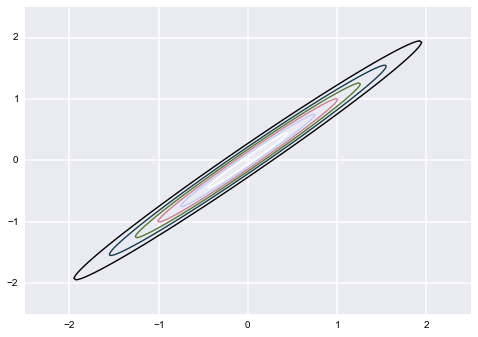

In [4]:
y = f(x0,x1)
plt.contour(x0, x1, y)
plt.show()

In [5]:
def mcmc(x0, e, n, m, logf):
    r = np.random.random(n)
    xold = x0
    res = np.zeros((n, m))
    count = 0
    for i in xrange(n):
        xnew = np.random.normal(loc=xold, scale=e, size=m)
        if np.log(r[i]) < logf(xnew[0], xnew[1]) - logf(xold[0], xold[1]):
            xold = xnew
            count += 1
        res[i,:] = xold
    print "The acceptance rate of the chain is " + str(count/float(n))+"."
    return res

In [6]:
x0 = np.array([0.0,0.0])
e = 0.2
n = 50000
m = 2
res = mcmc(x0, e, n,m, logf)
burnin = 10000
res = res[burnin:,:]

The acceptance rate of the chain is 0.499.


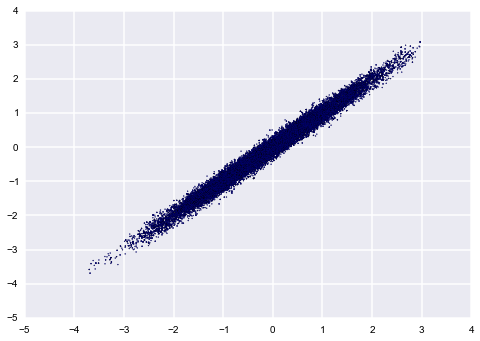

In [7]:
plt.scatter(res[:,0], res[:,1], s=1)
plt.show()

In [8]:
auto = acf(res[:,0], nlags = 150)

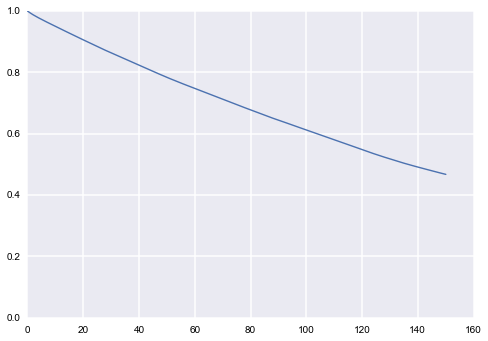

In [9]:
plt.plot(auto)
plt.ylim((0,1))
plt.show()

### Hamiltonian Monte Carlo

Now that we have the tools in place, let's describe the HMC algorithm.  We're going to assume as above a Kinetic Energy $ K(p) = \frac{p^{\top}M^{-1}p}{2}  $.  The distribution we would like to sample from is $f(q)$ and let $U(q)=-\log(f(q))$. The algorithm is as follows

* for i=1:N_samples
    1. Draw $  p \sim N(0,M) $
    2. Set $ q_{c} = q^{(i)} $ where the subscript $c$ stands for current
    3. $ p_c = p $
    4. Update momentum before going into LeapFrog stage: $ p = p_c - \frac{\epsilon * \nabla U(q_c)}{2} $ and let $q = q_{c}$. We will update $p$ and $q$.  
    5. LeapFrog to get new proposals. For j=1:L
        * $ q = q + \epsilon  p/M $
        * if not the last step, $ p = p - \epsilon  \nabla U(q) $
    6. Complete leapfrog: $ p = p - \frac{\epsilon  \nabla U(q)}{2} $
    7. $ p= -p $
    8. $ U_c = U(q_c), \,\,\, K_c = \frac{p_c^{\top}M^{-1}p_c}{2} $
    9. $ U = U(q), \,\,\, K = \frac{p^{\top}M^{-1}p}{2} $
    10. $ r \sim \rm{Unif}(0,1) $
    11. if $ r < e^{(U_{c}-U+K_{c}-K)} $ (we could compute as $\log(r)< \log(f(q))-\frac{p^{\top}M^{-1}p}{2}-\log(f(q_c)) + \frac{p_c^{\top}M^{-1}p_c}{2}$
       * accept $q_i = q$
       * otherwise reject

In [11]:
dU= lambda q: np.array([q[0]*InvSigma[0,0]+q[1]*InvSigma[0,1],q[1]*InvSigma[1,1]+q[0]*InvSigma[1,0]])

In [35]:
def HMC(q0, n, burnin, dU, logf, M, epsilon, L):
    qold = q0
    Q = np.zeros((n, 2))
    r = np.random.random(n)
    count = 0
    
    for i in xrange(n):
        p = np.random.normal(size = 2, loc=0, scale=np.sqrt(M))
        pold = p
        q = qold    
        p -= epsilon*dU(q)/2
        
        for j in xrange(L-1):
            q += epsilon*p/M
            p -= epsilon*dU(q)
        
        q += epsilon*p/M
        p -= epsilon*dU(q)/2
        qnew = q
        pnew = -p
        p = logf(qnew[0], qnew[1]) - (pnew**2).sum()/(2.*M) - logf(qold[0], qold[1]) + (pold**2).sum()/(2.*M) 
        if np.log(r[i]) < p:
            qold = qnew
            count += 1
        Q[i,:] = qold
        
    print "The acceptance rate is " + str(float(count)/n)+"."
    return Q[burnin:,:]

In [46]:
n = 20000
burnin = 5000
q0 = np.array([1.0,1.0])
m = 2
epsilon = 0.05
L = 10
M = 0.5
Q = HMC(q0,n, burnin, dU, logf, M, epsilon, L)

The acceptance rate is 1.0.


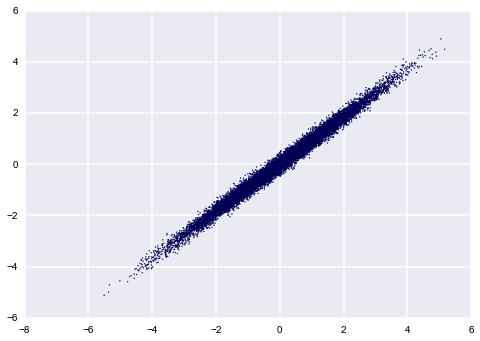

In [47]:
plt.scatter(Q[:,0], Q[:,1], s=1)
plt.show()

In [48]:
auto = acf(Q[:,0], nlags = 150)

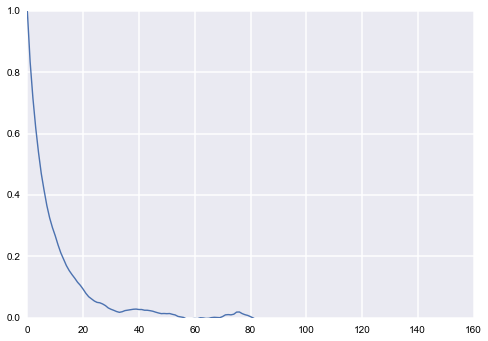

In [49]:
plt.plot(auto)
plt.ylim((0,1))
plt.show()

## Linear Regression

In statistics, linear regression is an approach for modeling the relationship between a scalar dependent variable $y$ and one or more explanatory variables (or independent variable) denoted $X$. For simplicity, if $X$ is a univariate variable, the model is as follows: $y_i = \beta_0+\beta_1 x_i+\epsilon_i, \epsilon\sim N(0,\sigma^2), 1\leq i\leq n.$

We fit the parameters such that $\rm{argmin}_{\beta_0,\beta}\sum_{i=1}^n |y_i-\beta_0-\beta x_i|^2.$

The solution is $\hat{\beta} = \frac{\rm{cov}(x,y)}{\rm{var}(x)},\ \hat{\beta_0} = \bar{y} - \hat{\beta}\bar{x}.$

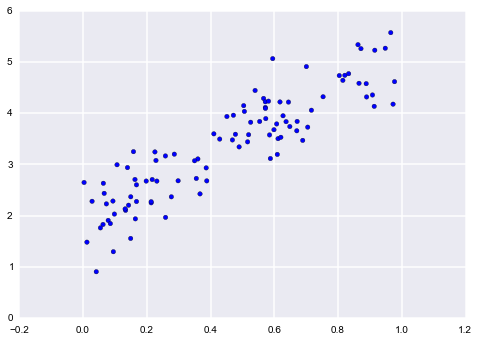

In [50]:
beta0 = 2
beta = 3
n = 100
sigma = 0.5
x = np.random.random(size = n)
y = beta0+beta*x+np.random.normal(size=n, loc=0, scale=sigma)
plt.scatter(x,y)
plt.show()

In [51]:
data = pd.DataFrame({'x': x, 'y': y})
model = ols("y ~ x", data).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     408.0
Date:                Sun, 29 Mar 2015   Prob (F-statistic):           1.04e-36
Time:                        01:16:33   Log-Likelihood:                -62.326
No. Observations:                 100   AIC:                             128.7
Df Residuals:                      98   BIC:                             133.9
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.8881      0.086     21.857      0.000         1.717     2.060
x              3.2787      0.162     20.200      0.0

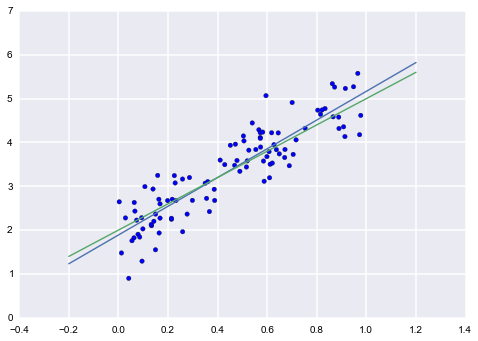

In [52]:
x0 = np.linspace(-0.2,1.2,100)
y0 = model.params[0]+model.params[1]*x0
yreal = beta0+beta*x0
plt.scatter(x,y)
plt.plot(x0,y0)
plt.plot(x0,yreal)
plt.show()

What if there are some outliers?

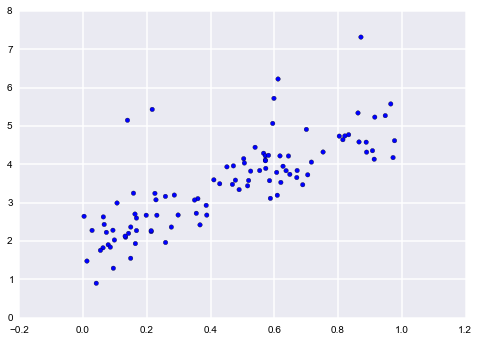

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     171.1
Date:                Sun, 29 Mar 2015   Prob (F-statistic):           3.21e-23
Time:                        01:16:34   Log-Likelihood:                -106.81
No. Observations:                 100   AIC:                             217.6
Df Residuals:                      98   BIC:                             222.8
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.9905      0.135     14.769      0.000         1.723     2.258
x              3.3124      0.253     13.080      0.0

In [53]:
y[0:5] +=  2.0 + np.random.random(5)
plt.scatter(x,y)
plt.show()
data = pd.DataFrame({'x': x, 'y': y})
model = ols("y ~ x", data).fit()
print(model.summary())  

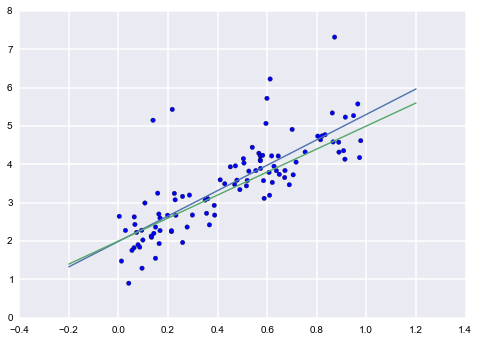

In [54]:
x0 = np.linspace(-0.2,1.2,100)
y0 = model.params[0]+model.params[1]*x0
yreal = beta0+beta*x0
plt.scatter(x,y)
plt.plot(x0,y0)
plt.plot(x0,yreal)
plt.show()

## Gelman-Rubin diagnostics

For the Gelman-Rubin diagnostics, we need to samplt multiple chains to get the test statistics. For example, let $z_{i,j}, 1\leq i\leq m, 1\leq j\leq n$ be the $j$th sample from the $i$th chain. We have already delete the burnin samples from each chain. The Gelman-Rubin statistics is defined as:

$$B=\frac{n}{m-1}\sum_{i=1}^m (\bar{z}_{i}-\bar{z})^2, \bar{z}_{i}=\frac{1}{n}\sum_{j=1}^n z_{i,j}, \bar{z}=\frac{1}{m}\sum_{i=1}^m \bar{z}_{i}$$

$$W=\frac{1}{m}\sum_{i=1}^m s_i^2, s_i^2=\frac{1}{n-1}\sum_{j=1}^n (z_{i,j}-\bar{z}_i)^2$$

$$\hat{\rm{var}}^{+}(z)=\frac{n-1}{n}W+\frac{1}{n}B$$

$$\hat{R} = \sqrt{\frac{\hat{\rm{var}}^{+}(z)}{W}}$$

$\hat{R}$ will decline to 1 as $n\to\infty$ if all the chains do not mix.

## Effective sample size

Now, we show a method to compute effective sample size with multiple chains. The effective sample size is defined as follows:

$$\rm{n}_{\rm{eff}}=\frac{mn}{1+2\sum_{t=1}^\infty \rho_t}$$

We estimate the autocorrelation $\rho_t$ by 

$$V_t = \frac{1}{m(n-t)}\sum_{i=1}^m\sum_{j=t+1}^n (z_{i,j}-z_{i,j-t})^2$$
$$\hat{\rho}_t=1-\frac{V_t}{\hat{\rm{var}}^{+}(z)}$$.

We compute a partial sum, starting from lag 0 and continuing until the sumo f autocorrelation estimates for two succesive lags $\hat{\rho}_{2t'}+\hat{\rho}_{2t'+1}$ is negative. We use this positive partial sum as our estimate of $\sum_{t=1}^\infty \rho_t$
$$\hat{n}_{\rm{eff}} = \frac{mn}{1+2\sum_{t=1}^T \hat{\rho}_t}$$

The function could be found as follows.